In [1]:
__author__ = 'Isidora Jankov <ijankov@proton.me>, Andjelka Kovacevic <andjelka@matf.bg.ac.rs>, Dragana Ilic <dilic@matf.bg.ac.rs>, Paula Sanchez-Saez <pasanchezsaez@gmail.com>, Robert Nikutta <robert.nikutta@noirlab.edu>'
__version__ = '20230411'
__keywords__ = ['extragalactic', 'lightcurve', 'quasars', 'variable', 'reverberation mapping']

# Photometric reverberation mapping of AGNs

*Authors: Isidora Jankov, Andjelka Kovacevic, Dragana Ilic, Paula Sánchez-Sáez, Robert Nikutta and Astro Data Lab Team*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Introduction to photometric reverberation mapping](#intro)
* [Imports & setup](#import)

**[Part I: Getting data](#part1)**
* [Alert light curves from ANTARES](#antares)
* [Downloading multiband light curves using ZTF API](#ztf)
* [Generating artificial photometric AGN light curves](#sim)

**[Part II: Photo RM on simulated data](#part2)**
* [Tools](#tools)
* [Step 1: Identify suitable filters](#step1)
* [Step 2 & 3: Calculate ACF and CCF using pyZDCF](#step23)
* [Step 4: Calculate $CCF(\tau)$](#step4)
* [Step 5: Estimate the time lag ($\tau$)](#step5)
* [Resources and references](#ref)

<a class="anchor" id="goals"></a>
# Goals

- Introduce three useful tools for obtaining photometric light curves: ANTARES API, ZTF API, and simulations;
- Introduce [`pyzdcf`](https://github.com/LSST-sersag/pyzdcf) module which emulates a widely used Fortran code for calculating cross-correlation of astronomical time-series using the ZDCF method ([Alexander 1997](https://ui.adsabs.harvard.edu/abs/1997ASSL..218..163A/abstract));
- Guide the reader through five stages of photometric reverberation mapping (PhotoRM) based on the formalism by [Chelouche \& Daniel (2012)](https://ui.adsabs.harvard.edu/abs/2012ApJ...747...62C/abstract);
- Utilize the introduced tools in the five-stage PhotoRM analysis example with simulated light curves.

# Summary

This notebook is a demonstration of techniques developed for the research published in [Kovačević et al. (2021b)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5012K/abstract) and [Jankov et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022AN....34310090J/abstract), and serves as a complete practical guide on how to perform photometric reverberation mapping of the broad line region of active galactic nuclei (AGN). 

In the first part, we will demonstrate three ways of acquiring photometric light curves: from alert broker ANTARES, from ZTF data releases, and by generating artificial light curves using the method described in [Kovačević et al. (2021b)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5012K/abstract). The second part demonstrates the photometric reverberation mapping method on a pair of simulated light curves, where `photRM` and `pyzdcf` modules are introduced and used.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution

If you use this notebook for your published science, please acknowledge the following:

* Jankov et al., "pyZDCF: Initial Release", Zenodo, 2022, http://dx.doi.org/10.5281/zenodo.7253034

* Jankov et al., "Photoreverberation mapping of quasars in the context of Legacy Survey of Space and Time observing strategies", Astronomische Nachrichten, 343, e210090, 2022, http://dx.doi.org/10.1002/asna.20210090]

* Kovačević et al., "On possible proxies of AGN light-curves cadence selection in future time domain surveys", MNRAS, 505, 5012, 2021, https://doi.org/10.1093/mnras/stab1595

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

*Many thanks to Prof. Eli Waxman, Amir Bar On and former students of Prof. Tal Alexander for their kind assistance regarding the development of pyZDCF module.*

<a class="anchor" id="intro"></a>
# Introduction to photometric reverberation mapping

<div style="text-align: justify"> Exploring transient optical sky (ETOS) is among four Rubin Observatory Legacy Survey of Space and Time (LSST) key science drivers (<a href="https://ui.adsabs.harvard.edu/abs/2019ApJ...873..111I/abstract">Ivezić et al. 2019</a>). We are motivated by the ETOS LSST science opportunity No. 14 (see item 14 in section 4, <a href="https://ui.adsabs.harvard.edu/abs/2019ApJ...873..111I/abstract">Ivezić et al. 2019</a>), which enables us to harness LSST light curves of active galactic nuclei (AGN) for photometric reverberation mapping (PhotoRM, <a href="https://ui.adsabs.harvard.edu/abs/2012ApJ...747...62C/abstract">Chelouche &amp; Daniel 2012</a>, <a href="https://ui.adsabs.harvard.edu/abs/2012ApJ...756...73E/abstract">Edri et al. 2012</a>). We are developing deep learning engines (DLEs, see <a href="https://ui.adsabs.harvard.edu/abs/2022AN....34310103A/abstract">Čvorović-Hajdinjak et al. 2022</a>) for non-parametric modeling and extracting of information from AGN light curves, which are directly related to the scientific objectives of the LSST Exploring transient optical sky. For more details on the project visit us on our <a href="https://github.com/LSST-sersag/dle">GitHub page</a>.
</div>

</br>

<div style="text-align: justify"> Here, we present our implementation of the PhotoRM method. The goal of PhotoRM is to calculate the broad line region radius using broadband photometric filters. Contrary to spectroscopic light curves, photometric light curves have continuum and line emission entangled, so classical cross-correlation is not applicable to those light curves. To mitigate this, <a href="https://ui.adsabs.harvard.edu/abs/2012ApJ...747...62C/abstract">Chelouche &amp; Daniel (2012)</a> developed a formalism in which the time lag between the continuum and emission line is obtained by looking for a peak in the difference between the cross-correlation and auto-correlation functions of light curves in specific filters covering continuum and continuum + line emission. While spectroscopic methods provide greater accuracy, photometric data, which is necessary for PhotoRM, is easier to obtain. This is because photometric observations are more time-efficient and are already widely available in current databases. Additionally, even more data is expected to become available in the future from sky surveys such as LSST.
</div>

</br>
    
<div style="text-align: justify"> To illustrate this further, we can consider a low redshift ($z = 0.005$) AGN. Here, the continuum emission is covered by the $i$-band and H$\alpha$ line emission (superimposed on the continuum) is covered by the $r$ band. In this case, we can use light curves in $i$ and $r$ filters to measure the lagged response of the H$\alpha$ line behind the continuum, which would be equivalent to using spectroscopic light curves of the continuum and H$\alpha$ emission line. Note that we can't always use the same lines and corresponding filters to estimate the BLR dimension because at larger redshifts Balmer lines will tend to shift outside of the optical filter coverage, in which case different emission lines must be used for PhotoRM.
</div>

</br>
    
<div style="text-align: justify"> You can try entering different redshift values in the <code>filters_viz()</code> function in the following cell to see how it affects filter coverage of the composite quasar spectrum (<a href="https://ui.adsabs.harvard.edu/abs/2001AJ....122..549V/abstract">Vanden Berk et al. 2001</a>). This can be useful when choosing appropriate filters for performing PhotoRM at a particular redshift. The <code>filters_viz()</code> function accepts a wide range of photometric systems including LSST, SDSS and ZTF. Additionaly, you can use other photometric systems that are available in the <code>speclite</code> package (e.g., 'bessell-*', 'gaiadr2-*', etc.). </div>

In [12]:
#### it is requred to instal speclite before executing rest of the code ###
# !pip install speclite
# !pip install antares_client


ERROR: Could not find a version that satisfies the requirement antares_client.search (from versions: none)
ERROR: No matching distribution found for antares_client.search


In [13]:
from antares_client.search import search

In [50]:
# !pip install pyzdcf

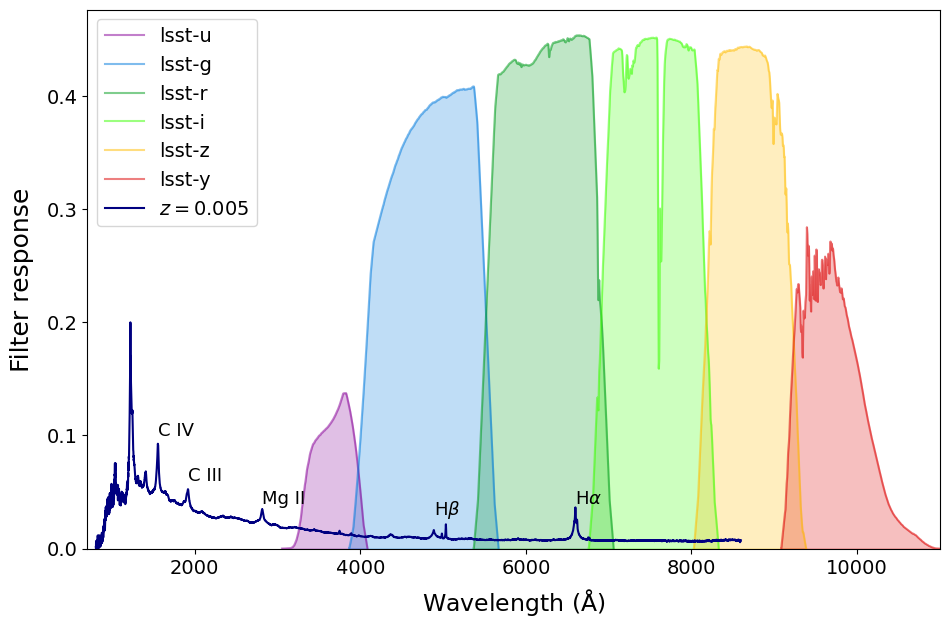

In [5]:
import photRM
import speclite

photRM.filters_viz(z=0.005, phot_sys='LSST', save=False, comp_spec_path='./data/')

# most of the effort for this tutorial is put in the installing all the required packages
# whole folder TimeDomain is downloaded in order to notebook run
# after installing speclite, code runs fine

The first part of this notebook will demonstrate how to obtain the real and simulated photometric light curves and the second part is designed to guide the reader through our Python implementation of the PhotoRM method, summerized in these five steps: 

**PhotoRM Steps:**

- identify suitable filters: one needs to cover continuum emission ($X$-band) and the other needs to cover continuum + line emission ($Y$-band).
- calculate the auto-correlation function (ACF) of the continuum light curve ($X$-band)
- calculate the cross-correlation function (CCF) between the continuum light curve  ($X$-band) and the continuum+line light curve ($Y$-band)
- subtract ACF from CCF:
 </div>

$$
\begin{align}
CCF(\tau) = CCF_{YX}(\tau) - ACF_{X}(\tau)
\end{align}
$$

- find the peak in their difference, it will correspond to the time-lag ($\tau$)

<a class="anchor" id="import"></a>
# Imports and setup

In [17]:
# Standard lib
import os
import warnings

# 3rd party libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from antares_client.search import search

%matplotlib inline

# Custom libs
import photRM
from pyzdcf import pyzdcf

<a class="anchor" id="part1"></a>

# Part I: Getting data

<a class="anchor" id="antares"></a>
## 1. Alert light curves from ANTARES

This section describes how to retrieve ZTF light curves
derived by the ANTARES alert broker, using their Elasticsearch
API. It can search on ZTF object ID, RA, DEC, or other properties (for more details please check [AntaresVariableRCBStars notebook](https://github.com/astro-datalab/notebooks-latest/blob/master/05_Contrib/TimeDomain/AntaresExample/AntaresVariableRCBStars.ipynb)). Here, we will search the ANTARES database using RA and DEC
from our example user-provided catalog containing some basic
properties of known AGNs.

Besides showing how to use ANTARES API the goal of this and
the following section is to highlight the diﬀerence between light
curves obtained from alert brokers such as ANTARES and light
curves from survey data releases such as ZTF Data Release 11.

In [18]:
# Load example catalog
sources = pd.read_csv('./data/obj_catalog.csv')
sources.head()

,objID,name,ra,dec,z,type
0,1.289910e+17,SDSS J081109.38+172928.9,122.789120,17.491364,0.39,Q
1,1.605320e+17,SDSS J162206.75+434636.7,245.528148,43.776861,0.66,Q
2,1.799120e+17,SDSS J124157.25+595528.1,190.488562,59.924505,0.63,Q
3,1.337840e+17,SDSS J235939.10+212908.3,359.912939,21.485675,1.71,Q
4,1.061410e+17,SDSS J092030.98-013253.2,140.129104,-1.548115,2.24,Q


*This is a subset of combined catalog of known AGNs described in [Sánchez-Sáez, P. et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021AJ....162..206S/abstract)*

In [19]:
# ANTARES API Elasticsearch

warnings.filterwarnings("ignore")


# Select first 5 objects
ra = sources.ra.iloc[:5]
dec = sources.dec.iloc[:5]

lc_list = []    # For storing light curve data from successful search hits
locus_list = [] # For storing locus_id (id from ANTARES)


# Query first 5 light curves based on their RA and DEC using ANTARES client
for i in range(len(ra)):  
    print("Iteration: ",i, "ra",ra[i],"dec",dec[i])
    query = {
        "query": {
            "bool": {
                "must": [
                    {
                        "range": {
                            "ra": {
                                "gte": ra[i]-1./3600.,
                                "lte": ra[i]+1./3600.,
                            }
                        }
                    },
                    {
                        "range": {
                            "dec": {
                                "gte": dec[i]-1./3600.,
                                "lte": dec[i]+1./3600.
                            }
                        }
                    }
                 ]
            }
        }
    }
    # In ANTARES alerts are aggregrated on the same point of sky to form a locus object
    keys = {}
    for locus in search(query):
        df = locus.timeseries.to_pandas() # convert locus object to pandas series
        df = df[['ant_mjd', 'ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf']]
        dn = df.dropna()
        print("Got a hit on locus_id: ",locus.locus_id)
        for i,j in zip(dn.ztf_fid.value_counts().index, dn.ztf_fid.value_counts()):
            if i == 1: i = 'g'
            elif i == 2: i = 'r'
            elif i== 3: i = 'i'
            print(f"--> number of points in {i} band: {j}")
        lc_list.append(dn)
        locus_list.append(locus.locus_id)

Iteration:  0 ra 122.78912 dec 17.491364
Got a hit on locus_id:  ANT2020pn2g4
--> number of points in r band: 93
--> number of points in g band: 51
Iteration:  1 ra 245.528148 dec 43.776861
Iteration:  2 ra 190.488562 dec 59.924505
Iteration:  3 ra 359.912939 dec 21.485675
Iteration:  4 ra 140.129104 dec -1.548115


We had only one successful hit out of five and it corresponds to 'SDSS J081109.38+172928.9' from our catalog.

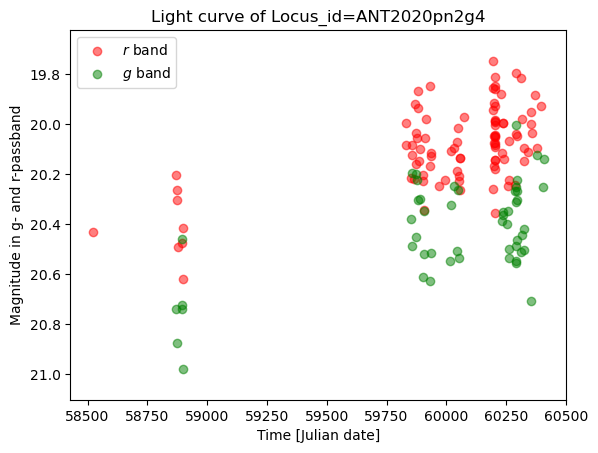

In [20]:
# Astro Data Lab

lc_data = lc_list[0]
locus_id = locus_list[0]

# Plot the downloaded light curves

MIN = min(lc_data['ztf_magpsf'])
MAX = max(lc_data['ztf_magpsf'])
plt.ylim(MAX+0.1*(MAX-MIN), MIN-0.1*(MAX-MIN))    
plt.scatter(lc_data['ant_mjd'][lc_data['ztf_fid']==2], lc_data['ztf_magpsf'][lc_data['ztf_fid']==2],
            c='red', alpha=0.5, label=r'$r$ band')
plt.scatter(lc_data['ant_mjd'][lc_data['ztf_fid']==1], lc_data['ztf_magpsf'][lc_data['ztf_fid']==1],
            c='green', alpha=0.5, label=r'$g$ band')
plt.title('Light curve of Locus_id={}'.format(locus_id))
plt.xlabel('Time [Julian date]')
plt.ylabel('Magnitude in g- and r-passband')
plt.legend()
plt.show()

In [51]:
no_r = len(lc_data.loc[lc_data['ztf_fid']==2])
no_g = len(lc_data.loc[lc_data['ztf_fid']==1])

print(f'Light curve in g band has {no_g} points')
print(f'Light curve in r band has {no_r} points')

### IMPROVEMENT ###
# file names for number of red and green points are changed from 'nr' to 'no_r'
# in order to improve reader comprehension of the tutorial

Light curve in g band has 51 points
Light curve in r band has 93 points


As you can see, there is very little data in both filters. For comparison, we will now query the same coordinates in the ZTF Data Release light curve database using ZTF API.

<a class="anchor" id="ztf"></a>
## 2. Downloading multiband light curves using ZTF API

In this section, we show how to download ZTF Data Release light curves, using the ZTF API. 
For more details about the ZTF service, go to their documentation: https://irsa.ipac.caltech.edu/data/ZTF/docs/releases/dr08/ztf_release_notes_dr08.pdf
See section "iii. Querying Lightcurves using the API"

More details can be found here: https://irsa.ipac.caltech.edu/docs/program_interface/ztf_lightcurve_api.html

**NOTE**: to use this API, you must have `wget` installed.

In [22]:
def get_ZTF_DR_lc(name, ra, dec, band, dr_path, keep_all_columns = False):
    
    """
    Function to download an individual ZTF light curve using the ZTF API. 
    
    
    Parameters:
    -----------
    name: str
        Object name (e.g. the object "SDSS J005132.94+180120.5" should be refered here only
        by "J005132.94+180120.5")
    ra: float
        Right ascension of the object (in degrees).
    dec: float
        Declination of the object (in degrees).
    band: {'g', 'r', 'i'}
        ZTF photometric band.
    dr_path: str
        Path to the download directory.
    keep_all_columns: bool, default=False
        If False, only the most important light curve parameters will be retrieved. 
        Otherwise, keep all the columns.
        
    Returns:
    --------
    df: pd.DataFrame
        DataFrame containing the measurments of the retrieved light curve.
    """
    
    # download light curve from ZTF unless it already exists in the local folder
    if not os.path.exists(dr_path+name+'_DR_'+band+'band.csv'):
        cmd = 'wget -O '+dr_path+name+'_DR_'+band+'band.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE '+str(ra)+' '+str(dec)+' 0.000277778&BANDNAME='+band+'&FORMAT=csv"'
        os.system(cmd)
    
    df = pd.read_csv(dr_path+name+'_DR_'+band+'band.csv')
    
    if keep_all_columns is False:
        # here we select the most important columns.
        df = df[['oid','mjd','mag','magerr','catflags','filtercode','ra','dec']]
        df.to_csv(dr_path+name+'_DR_'+band+'band.csv', index=False)
    
    print("DR lc for object %s in band %s saved" % (name,band))

    return(df)

Let's use this function to download light curves in all three bands ($g$, $r$ and $i$) using RA and DEC from a user provided object catalog.

In [23]:
sources.tail()

,objID,name,ra,dec,z,type
993,1.210520e+17,SDSS J132236.41+105239.4,200.651753,10.877598,1.70,Q
994,1.534410e+17,SDSS J081343.48+375228.0,123.431207,37.874464,2.83,Q
995,1.774620e+17,SDSS J123749.62+575319.5,189.456754,57.888759,1.69,Q
996,1.090240e+17,SDSS J232953.52+005106.6,352.473052,0.851835,0.50,Q
997,1.436210e+17,SDSS J085246.02+294107.6,133.191794,29.685440,2.12,Q


*This is a subset of combined catalog of known AGNs described in [Sánchez-Sáez, P. et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021AJ....162..206S/abstract)*

As you can see, this catalog has a column 'name' but the name of the object is not in the correct format to use in the `get_ZTF_DR_lc()` function. We need to clean the data:

In [24]:
# Select only relevant part of the object name (exclude 'SDSS ')
sources['name'] = sources['name'].str.replace('SDSS ','')
sources.tail()

,objID,name,ra,dec,z,type
993,1.210520e+17,J132236.41+105239.4,200.651753,10.877598,1.70,Q
994,1.534410e+17,J081343.48+375228.0,123.431207,37.874464,2.83,Q
995,1.774620e+17,J123749.62+575319.5,189.456754,57.888759,1.69,Q
996,1.090240e+17,J232953.52+005106.6,352.473052,0.851835,0.50,Q
997,1.436210e+17,J085246.02+294107.6,133.191794,29.685440,2.12,Q


In [25]:
dr_path = './ZTF_data/ZTF_DR_data/' # where to save the DR light curve data in csv format

# Download g, r and i band light curves for first 5 objects in the catalog 
name = sources.name[:5]
ra = sources.ra[:5]
dec = sources.dec[:5]

for i in range(len(ra.values)): # use the proper names for the name, RA, and dec columns from your catalog
    lcg = get_ZTF_DR_lc(name[i],ra[i],dec[i],'g',dr_path)
    lcr = get_ZTF_DR_lc(name[i],ra[i],dec[i],'r',dr_path)
    lci = get_ZTF_DR_lc(name[i],ra[i],dec[i],'i',dr_path)
    print(62*'-')    

DR lc for object J081109.38+172928.9 in band g saved
DR lc for object J081109.38+172928.9 in band r saved
DR lc for object J081109.38+172928.9 in band i saved
--------------------------------------------------------------
DR lc for object J162206.75+434636.7 in band g saved
DR lc for object J162206.75+434636.7 in band r saved
DR lc for object J162206.75+434636.7 in band i saved
--------------------------------------------------------------
DR lc for object J124157.25+595528.1 in band g saved
DR lc for object J124157.25+595528.1 in band r saved
DR lc for object J124157.25+595528.1 in band i saved
--------------------------------------------------------------
DR lc for object J235939.10+212908.3 in band g saved
DR lc for object J235939.10+212908.3 in band r saved
DR lc for object J235939.10+212908.3 in band i saved
--------------------------------------------------------------
DR lc for object J092030.98-013253.2 in band g saved
DR lc for object J092030.98-013253.2 in band r saved
DR lc 

In [26]:
# Read the downloaded light curves for one object
obj_name = 'J081109.38+172928.9'
print("Object name: SDSS", obj_name)

lc_g = pd.read_csv(dr_path+obj_name+'_DR_'+'g'+'band.csv')
lc_r = pd.read_csv(dr_path+obj_name+'_DR_'+'r'+'band.csv')
lc_i = pd.read_csv(dr_path+obj_name+'_DR_'+'i'+'band.csv')

# Show an example of the light curve table in one band
print("Band: r")
lc_r.tail()

Object name: SDSS J081109.38+172928.9
Band: r


,oid,mjd,mag,magerr,catflags,filtercode,ra,dec
976,1562214300013414,58884.202465,19.206236,0.069675,0,zr,122.789068,17.491424
977,1562214300013414,58891.266563,19.164740,0.067566,0,zr,122.789113,17.491408
978,1562214300013414,58891.267928,19.183571,0.068516,0,zr,122.789106,17.491340
979,1562214300013414,58892.269213,19.099239,0.064354,0,zr,122.789119,17.491393
980,1562214300013414,58892.269664,19.132296,0.065957,0,zr,122.789150,17.491393


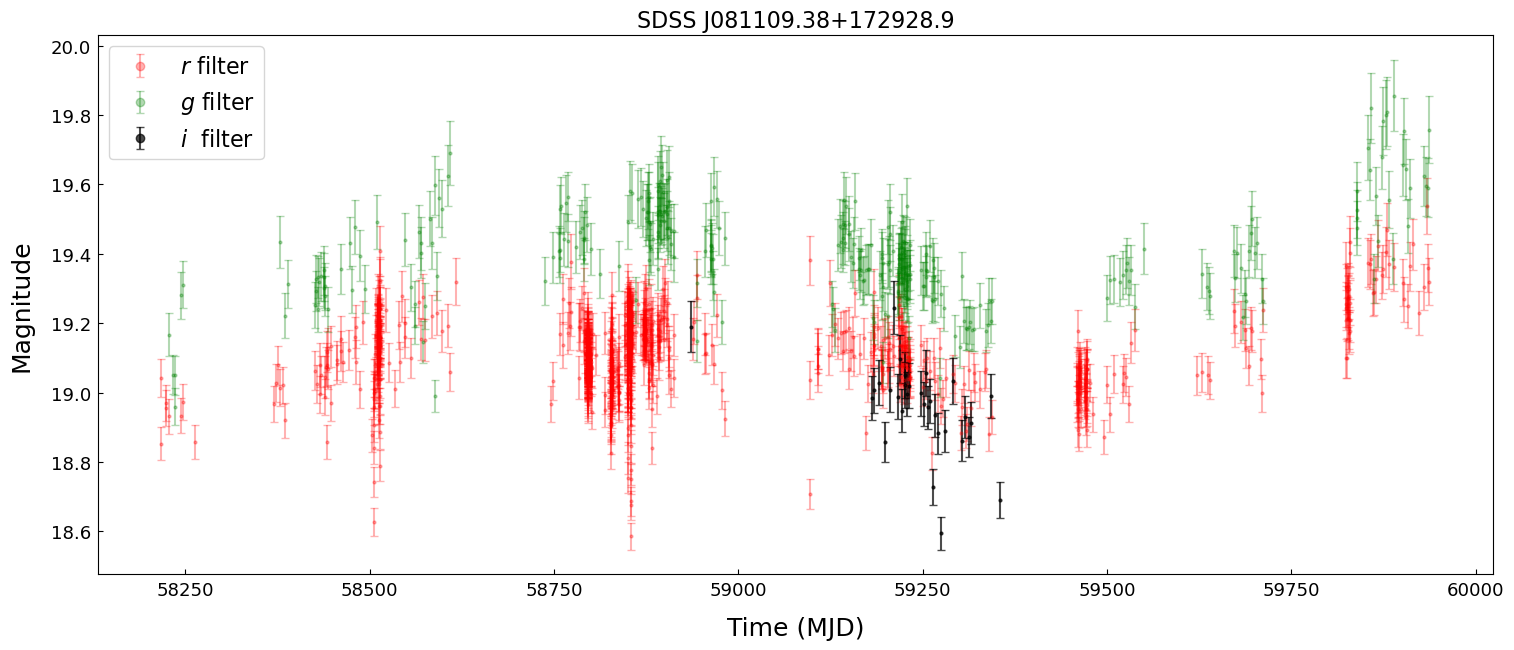

In [55]:
# Plot the light curves       
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot()

ax.errorbar(lc_r.mjd,lc_r.mag,yerr=lc_r.magerr,fmt='ro',markersize=2,alpha=0.3,capsize=3,label=r'$r$ filter')
ax.errorbar(lc_g.mjd,lc_g.mag,yerr=lc_g.magerr,fmt='go',markersize=2,alpha=0.3,capsize=3,label=r'$g$ filter')
ax.errorbar(lc_i.mjd,lc_i.mag,yerr=lc_i.magerr,fmt='ko',markersize=2,alpha=0.7,capsize=3,label=r'$i$  filter')

ax.set_xlabel('Time (MJD)',fontsize = 18, labelpad=12)
ax.set_ylabel('Magnitude',fontsize = 18,labelpad=12)
ax.tick_params(direction='in', pad = 5, labelsize=13)
ax.legend(fontsize=16, markerscale=3)
ax.set_title("SDSS {}".format(obj_name), size=16)
plt.show()

### IMPROVEMENT ###
# alpha for different filters are changed in order to highliht i filter (with higher alpha)
# otherwise, they are practicaly invisible in the graph

In [28]:
print("Light curve in g band has {} points.".format(len(lc_g)))
print("Light curve in r band has {} points.".format(len(lc_r)))
print("Light curve in i band has {} points.".format(len(lc_i)))

### now we can see that i filter has only 31 points that are mostly grouped around 59250 date ###

Light curve in g band has 315 points.
Light curve in r band has 981 points.
Light curve in i band has 31 points.


This is a significant improvement compared to ANTARES light curves, where we had only 20 and 34 points in the $g$ and $r$ bands, respectively.

<a class="anchor" id="sim"></a>
## 3. Generating artificial photometric AGN light curves

Although the origin of AGN variability is still debated, it is agreed upon that optical AGN light curves can be sucessfully described by a Damped Random Walk (DRW) model ([Kelly et al. 2009](https://ui.adsabs.harvard.edu/abs/2009ApJ...698..895K/abstract)). Furthermore, the DRW parameters have been linked to physical properties of quasars, such as the black hole mass and luminosity of AGN. With this knowledge, it is possible to generate artificial AGN light curves. 

One approach to generating artificial AGN light curves is described in [Kovačević et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5012K/abstract) where the monochromatic luminosity at $5100$ $\unicode{x212B}$ is randomly drawn from a range of values $\mathrm{log} L \in [42.2, 45.5]$ and used as a parameter in distributions (Eq. 22 and 25 [Kelly et al. 2009](https://ui.adsabs.harvard.edu/abs/2009ApJ...698..895K/abstract)) from which we draw the DRW model parameters ($\sigma$ - characteristic amplitude, $\tau$ - time-scale of exponentially-decaying variability). Then, these DRW parameters are plugged into a DRW model to generate AGN light curve points (Eq. 5 in [Kovačević et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5012K/abstract)). This process is implemented in the `lc_conti()` function from the `photRM` module located inside
this folder.

In the PhotoRM context, light curves generated this way can be treated as *pure continuum* light curves ($X$ filter, see PhotoRM steps in the Introduction), because DRW is shown to be successful in modeling the optical thermal emission of the accretion disk. We still need *continuum + emission line* light curves - the ones that would be lagging behind the continuum and account for the variability of both the continuum and the emission line (i.e., the $Y$ filter). These light curves can be obtained in the following way: 
- First, convolve a pure continuum light curve with a Gaussian kernel with the mean equal to the BLR radius ($R_{BLR}$) and standard deviation set to $\frac{1}{2}\sqrt{R_{BLR}}~$ (see Section 2.1.2 of [Chelouche and Daniel (2012)](https://ui.adsabs.harvard.edu/abs/2012ApJ...747...62C/abstract) for more details); this is how we get the emission line response curve. 
- Second, sum the response with a pure continuum light curve using realistic weights (e.g. 0.8 for the continuum and 0.2 for the response) to obtain the final light curve as it would appear in the $Y$ filter.

Using the model described above we will simulate two photometric AGN light curves (by calling the `lc_two_bands()` function from `photRM` module): 
- one covering the continuum emission only ($X$-band)
- the other one covering both the continuum and emission line together ($Y$-band) 

In [29]:
help(photRM.lc_two_bands)

Help on function lc_two_bands in module photRM:

lc_two_bands(T, osc=True, A=0.14, noise=5e-05, z=0, method='Kelly1', lag='random', lum='random', wl=0.2, wc=0.8, plot_kernel=False)
    Generate two artificial light curves: 
        
        - one in the hypothetical X band covering solely the continuum emission;
        - one in the hypothetical Y band covering some emission line and its
          surrounding continuum;
    
    The X band light curve is generated using a stochastic model based on the 
    Damped random walk (DRW) proccess (see lc_conti() docs). The Y band light
    curve is modeled using a method described in Jankov et al. (2022) which is 
    based on the photoRM formalism by Chelouche & Daniel (2012).
    
    Parameters
    ----------
    T: int
        Total time span of the light curve. It is recommended to generate light
        curves to be at least 10 times longer than their characteristic 
        timescale (Kozłowski 2017). 
    osc: bool, default=True
     

In [91]:
### IMPROVEMENT ###
# random seed is changed (from 0) in order to explore different results

np.random.seed(5)

# Generate light curves in two different bands
x_band, y_band, line_response =\
    photRM.lc_two_bands(6000,osc=True,A=0.14,noise=0.00005,z=0,lag='random',wl=0.2,wc=0.8,plot_kernel=False)

Properties of the simulated AGN object:
---------------------------------------
log(L) = 42.93
MBH = 2.83e+06 M_sun
tau_DRW = 15.10 days
sigma_DRW = 0.06 mag^2/day
Time-lag = 9.08 days


We generated an AGN object with bolometric luminosity drawn at random from the interval [42.2,45.5]. The black hole mass is determined using this luminosity, Eddington luminosity ([Woo & Urry 2002](https://iopscience.iop.org/article/10.1086/342878/fulltext/)) and Eddington ratio (eq. 18, [Shankar et al. 2009](https://iopscience.iop.org/article/10.1088/0004-637X/690/1/20/pdf)). The characteristic radius of the BLR (time-lag) is approximated by the empirical radius-luminosity relationship ([Bentz et al. 2013](https://iopscience.iop.org/article/10.1088/0004-637X/767/2/149/pdf)) and the DRW model parameters are obtained using the regression analysis results from [Kelly et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009ApJ...698..895K/abstract).

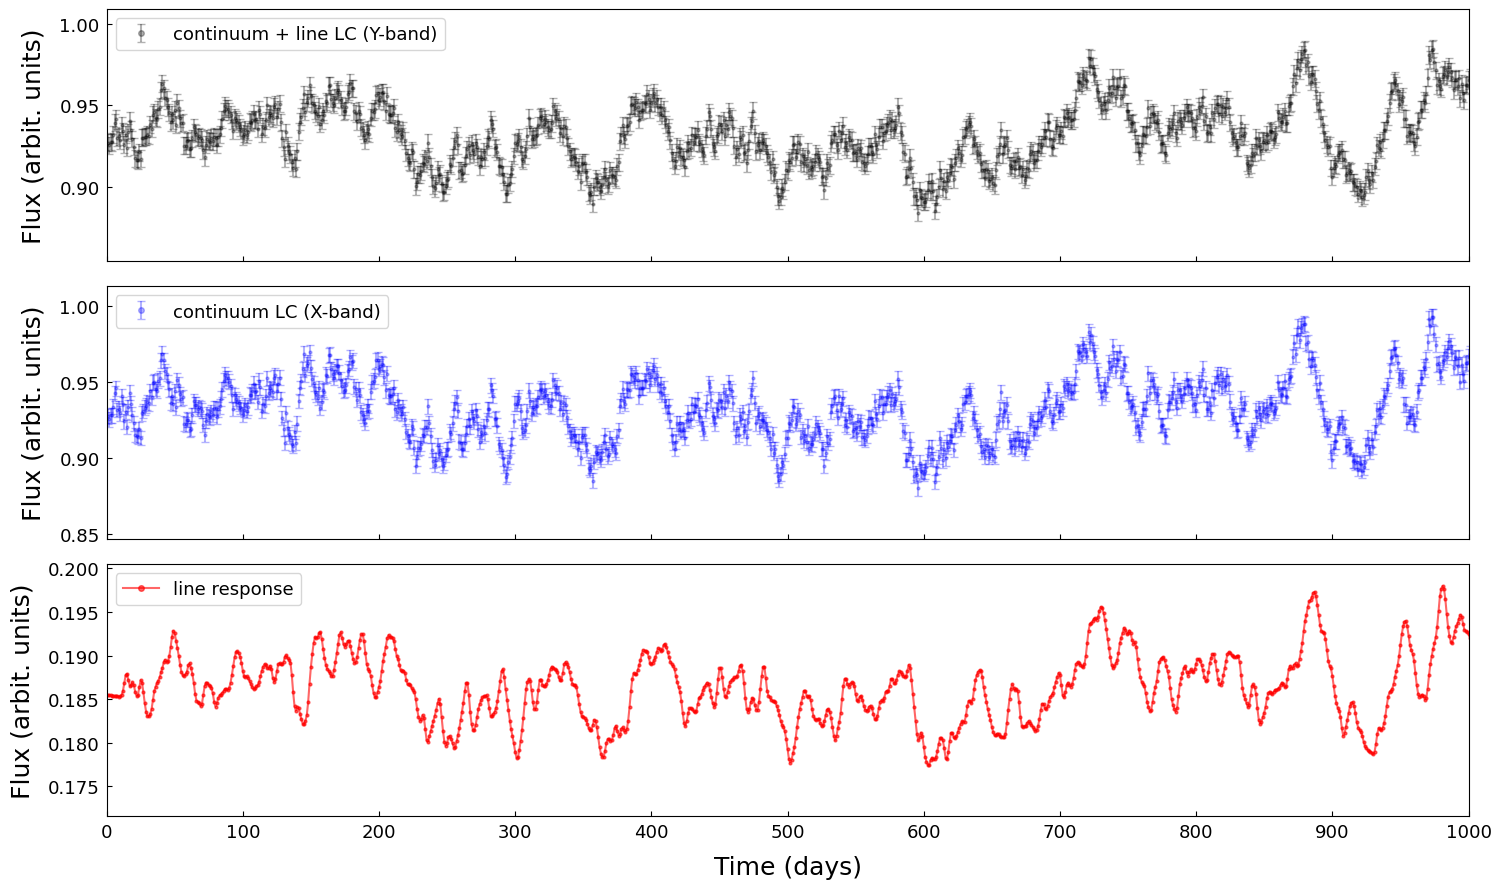

In [92]:
# Plot the light curves       
fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(15,9),tight_layout=True)
ax1.errorbar(y_band['t'],y_band['flux'],yerr=y_band['err'],fmt='ko',markersize=2,alpha=0.3,capsize=3,label='continuum + line LC (Y-band)')
ax2.errorbar(x_band['t'],x_band['flux'],yerr=x_band['err'],fmt='bo',markersize=2,alpha=0.3,capsize=3,label='continuum LC (X-band)')
ax3.plot(line_response['t'], line_response['flux'],'ro-', markersize=2,alpha=0.6, label='line response')

loc = plticker.MultipleLocator(100) # this locator puts ticks at regular intervals

for ax in [ax1,ax2,ax3]:
    ax.legend(fontsize=13,markerscale=2)
    ax.set_ylabel('Flux (arbit. units)',fontsize=18,labelpad=10)
    ax.tick_params(direction='in',pad=5,labelsize=13)
    ax.set_xlim(0,1000)
    ax.xaxis.set_major_locator(loc)

ax3.set_xlabel('Time (days)',fontsize=18,labelpad=10)
plt.show()

### IMPROVEMENTS 
# alpha values for lines are decreased in order to get better visual inspection

In [93]:
# Save the data
dir_path = './data/'

cut = 1000
np.savetxt(dir_path+'x_band',np.c_[x_band.t[:cut],x_band.flux[:cut],x_band.err[:cut]],fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'y_band',np.c_[y_band.t[:cut],y_band.flux[:cut],y_band.err[:cut]],fmt=['%.1f','%.7e','%.7e'])

<a class="anchor" id="part2"></a>
# PART II: Photo RM

We now have our light curve data, let's recall the steps for performing photometric reverberation mapping:

- **STEP 1**: identify suitable filters: one needs to cover the continuum emission alone ($X$-band), and the other needs to cover the continuum + line emission ($Y$-band)</font>
- **STEP 2**: calculate the auto-correlation function (ACF) of the continuum light curve
- **STEP 3**: calculate the cross-correlation function (CCF) between the continuum light curve and the continuum + line light curve
- **STEP 4**: subtract ACF from CCF:
 </div>

$$
\begin{align}
CCF(\tau) = CCF_{YX}(\tau) - ACF_{X}(\tau)
\end{align}
$$

- **STEP 5**: find the peak in their difference, it will correspond to the time-lag ($\tau$)

<br>
<br>

Bellow is an illustration of the whole process assuming a hypothetical AGN with $z = 0.005$:

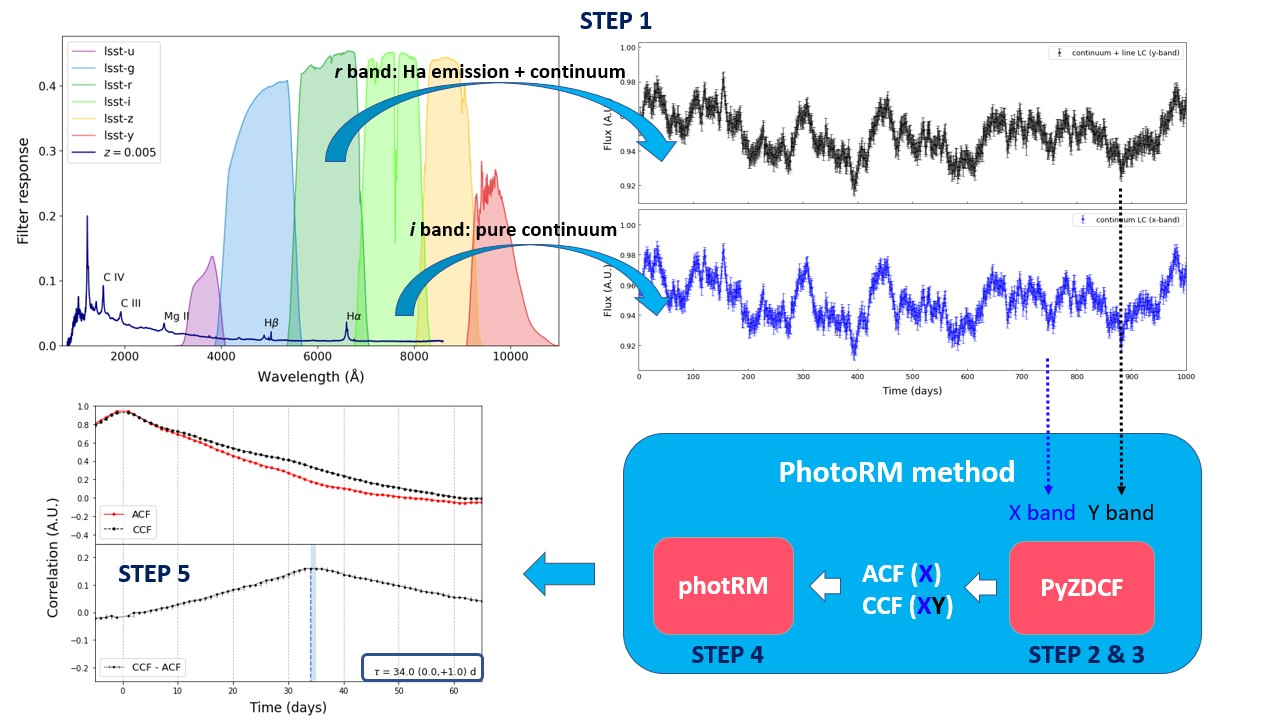

<a class="anchor" id="tools"></a>
## Tools:
### 1. pyZDCF

*The pyZDCF module is based on the original Fortran code fully developed by Prof. Tal Alexander from the Weizmann Institute of Science, Israel ([Tal Alexander 1997)](https://ui.adsabs.harvard.edu/abs/1997ASSL..218..163A/abstract).*

One of the most widely used methods for robust estimation of CCFs of discrete, sparse astronomical time-series (steps 2 \& 3) is the Z-transformed Discrete Correlation Function (ZDCF, Alexander 1997). Until now ZDCF had only a Fortran implementation. For the purpose of integrating the whole PhotoRM procedure in a Jupyter environment, we have rewritten and adapted ZDCF and made it available to Python users through a module called `pyzdcf`. Developing the python version was also motivated by the long and successful usage of the original ZDCF Fortran code in the investigation of light curves of AGN by our group (see [Kovacevic et al. 2014](https://ui.adsabs.harvard.edu/abs/2014AdSpR..54.1414K/abstract), [Shapovalova et al.
2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.485.4790S/abstract), and reference therein).

**<font color="blue">pyZDCF docs:</font>** see the full documentation [here](https://pyzdcf.readthedocs.io/en/latest/?badge=latest) or visit the [GitHub repo](https://github.com/LSST-sersag/pyzdcf).


**pyZDCF improvements to ZDCF:**

- **Sparse matrix implementation** for reduced RAM usage when working with long light curves (>3000 points). 

> The main benefit is that we can now run these demanding calculations on our own personal computers (8 GB of RAM is enough for light curves containing up to 15000 points), making the usage of this algorithm more convenient than ever. This could be even more apparent in the future, when 10-year-long light curves become available through LSST, especially if combined with data from multiple surveys. Also, new data-driven machine learning approaches are being developed to close the gaps in the light curves by adding more points based on the learned light curve patterns (e.g. [Čvorović-Hajdinjak et al. 2022](https://ui.adsabs.harvard.edu/abs/2022AN....34310103A/abstract)), further increasing the number of points per light curve.

- **Manual mode:** user can provide all parameters in one dictionary allowing for easy automation of calculations for a large number of light curves.

- **Fixed minor bugs** from the original ZDCF (v2.3) written in Fortran 95.


pyZDCF is already installed in the default notebook kernel at Data
Lab. If you are running this notebook on your local machine, you can
install it by un-commenting the cell below and running it:

In [19]:
#!pip install pyzdcf

### 2. photRM

`photRM` is a module with a two-fold purpose:
- provide tools for generating artificial AGN light curves and adapt them for testing of photoRM methods (based on original Python code by Dr. Andjelka Kovačević);
- provide tools for processing the results from `pyZDCF` or original `ZDCF` for the purpose of time-lag estimation based on the five-stage photoRM analysis presented in this notebook.

***

In this notebook, we provide instructions on how to use `pyZDCF` in the context of photometric reverberation mapping, although in principle, this program can be used with spectroscopic light curves also (same as the original Fortran version). For the sake of demonstration, we will perform the analysis with **simulated light curves** obtained by using the `photRM` module.

We also recommend looking at [Jankov et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022AN....34310090J/abstract), LSST Cadence Note ([Kovačević et al. 2021a](https://ui.adsabs.harvard.edu/abs/2021arXiv210512420K/abstract)), [Kovačević et al. 2021b](https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5012K/abstract) and [Kovačević et al. 2022](https://ui.adsabs.harvard.edu/abs/2022arXiv220806203K/abstract)  for interesting use cases of simulated light curves (e.g. as tools for evaluating Vera C. Rubin LSST survey strategies).

## PhotoRM steps

<a class="anchor" id="step1"></a>
### Step 1: Identify suitable filters

**<font color="blue">DONE</font>** (we simulated light curves in $X$ and $Y$ bands). 

This step tends to be more complicated if we work with real light curves. The `filters_viz()` function from our `photRM` module could be of use when deciding which bands to use for photoRM. In principle, for photoRM to work we need to provide a light curve in a band covering pure continuum and one other light curve in a band covering a prominent emission line superimposed on the continuum emission (see image above).

<a class="anchor" id="step23"></a>
### Step 2 & 3: Calculate ACF and CCF using pyZDCF

In [94]:
# Set input parameters for pyZDCF
input_dir = './data/'     # Path to the input light curve data
output_dir = './results/' # Path to the directory for saving the results

# Light curve names
lc1 = 'x_band'
lc2 = 'y_band'

In [95]:
# Step 2: ACF calculation

# Parameters are passed to pyzdcf as a dictionary
params = dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'acf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc1    # Name of the light curve file
             )

# Run pyzdcf
acf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

990 bins actually used, 45.0 inter-dependent pairs discarded.


acf.dcf written...

pyZDCF ended.



In [96]:
# Step 3: CCF calculation
params = dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'ccf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc1,   # Name of the first light curve file
              lc2_name          =  lc2    # Name of the second light curve file
             )

ccf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

992 bins actually used, 500032 inter-dependent pairs discarded.


ccf.dcf written...

pyZDCF ended.



In [97]:
acf.head()

,tau,-sig(tau),+sig(tau),dcf,-err(dcf),+err(dcf),#bin
0,1.0,0.0,0.0,0.890558,0.006645,0.006460,999.0
1,2.0,0.0,0.0,0.838848,0.009514,0.009265,998.0
2,3.0,0.0,0.0,0.782577,0.012440,0.012135,997.0
3,4.0,0.0,0.0,0.725509,0.015196,0.014850,996.0
4,5.0,0.0,0.0,0.671387,0.017616,0.017245,995.0


In [98]:
ccf.head()

,tau,-sig(tau),+sig(tau),dcf,-err(dcf),+err(dcf),#bin
0,-991.0,4.0,0.0,-0.161864,0.360182,0.386659,9.0
1,-989.0,1.0,0.0,-0.137697,0.322784,0.339949,11.0
2,-987.0,1.0,0.0,-0.206931,0.281872,0.301982,13.0
3,-985.0,1.0,0.0,-0.321392,0.238943,0.263169,15.0
4,-983.0,1.0,0.0,-0.161708,0.248081,0.259517,17.0


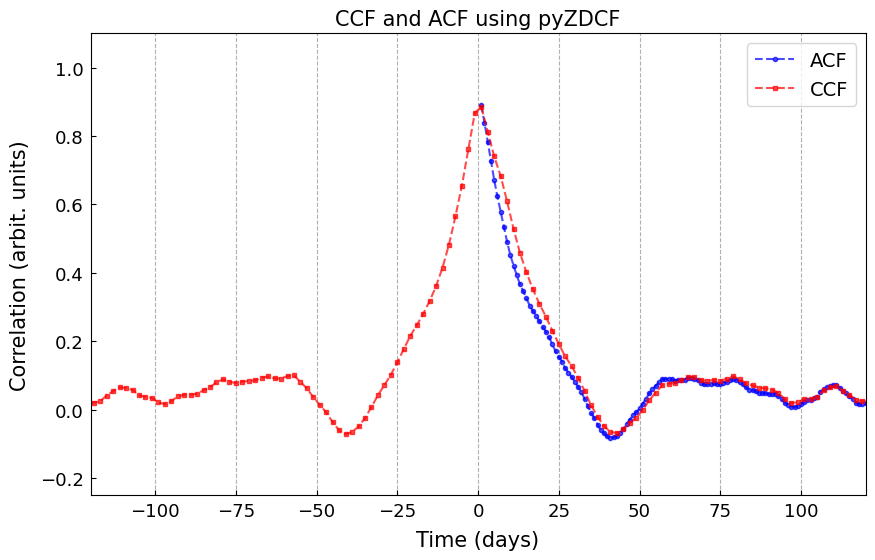

In [99]:
# Plot CCF and ACF
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(acf['tau'],acf['dcf'],'o--b',label='ACF',markersize=3, alpha=0.7)
ax.plot(ccf['tau'],ccf['dcf'],'s--r',label='CCF',markersize=3, alpha=0.7)

ax.set_xlim(-120,120)
ax.set_ylim(-0.25,1.1)
ax.set_xlabel("Time (days)",fontsize=15,labelpad=7)
ax.set_ylabel("Correlation (arbit. units)",fontsize=15,labelpad=7)
ax.legend(fontsize=14)
loc = plticker.MultipleLocator(25)
ax.xaxis.set_major_locator(loc)
ax.tick_params(direction='in', pad = 5,labelsize=13)
ax.set_title('CCF and ACF using pyZDCF',fontsize=15)
ax.grid(which='major',axis='x',linestyle='--')
plt.show()

### IMPROVEMENT ###
# again, alpha parameters  are changed for better presentation
# size of the markers are decreased because of the overlaping

<a class="anchor" id="step4"></a>
### Step 4: Calculate $CCF(\tau)$

We obtained the $CCF$ *(continuum & line)* and $ACF$ *(continuum)* functions using `pyZDCF`, and will now calculate $CCF(\tau)$.

In [100]:
# Since pyZDCF does not provide the ACF on the negative tau axis, we need to add it:
acf = photRM.add_inverted_acf(acf)

print('ACF shape: ',acf.shape)
print('CCF shape: ',ccf.shape)

ACF shape:  (1980, 7)
CCF shape:  (992, 7)


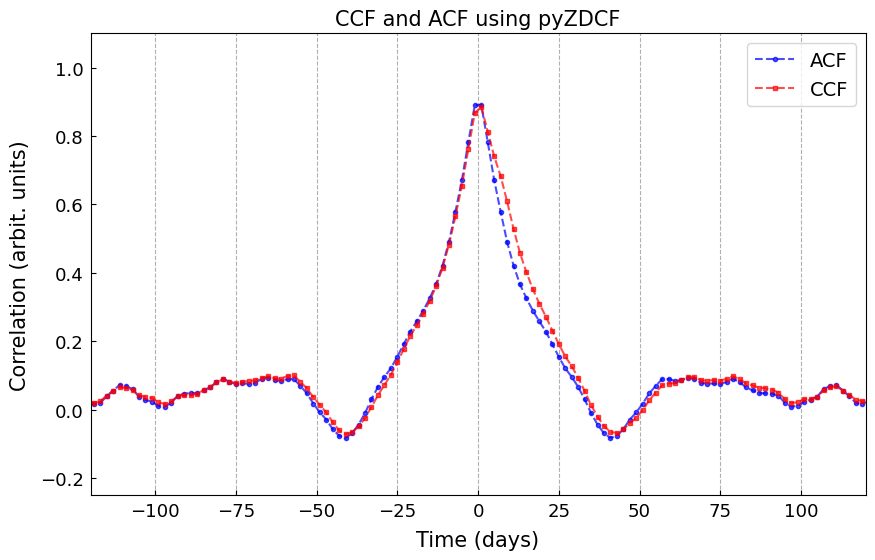

In [135]:
### IMPROVEMENT ###
# after adding negative values, we will plot it again 
# this time, we will define function for plotting 

# Plot CCF and ACF function

def plot_correlations (acf_file, ccf_file):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.plot(acf_file['tau'],acf_file['dcf'],'o--b',label='ACF',markersize=3, alpha=0.7)
    ax.plot(ccf_file['tau'],ccf_file['dcf'],'s--r',label='CCF',markersize=3, alpha=0.7)

    ax.set_xlim(-120,120)
    ax.set_ylim(-0.25,1.1)
    ax.set_xlabel("Time (days)",fontsize=15,labelpad=7)
    ax.set_ylabel("Correlation (arbit. units)",fontsize=15,labelpad=7)
    ax.legend(fontsize=14)
    loc = plticker.MultipleLocator(25)
    ax.xaxis.set_major_locator(loc)
    ax.tick_params(direction='in', pad = 5,labelsize=13)
    ax.set_title('CCF and ACF using pyZDCF',fontsize=15)
    ax.grid(which='major',axis='x',linestyle='--')
    plt.show()
    
plot_correlations (acf, ccf)

# it is more faster for computing!

We still need to make CCF and ACF the same length so we can subtract them.

In [103]:
# We do this by interpolating one of those functions to the time grid of the other.
acf = photRM.interp(ccf,acf) # first param is the function having the x-axis on which we want to interpolate the other function.
print('ACF shape: ',acf.shape)
print('CCF shape: ',ccf.shape)

ACF shape:  (992, 7)
CCF shape:  (992, 7)


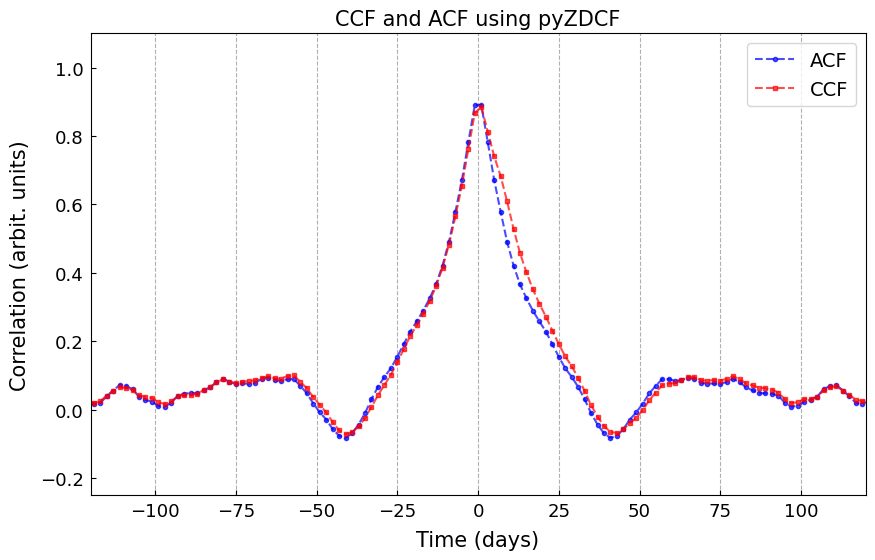

In [136]:
### IMPROVEMENT ###
# let's print it again with same shape values

plot_correlations (acf, ccf)

In [121]:
# Subtracting CCF and ACF
final_ccf = photRM.delta_ccf(acf, ccf)

In [122]:
final_ccf.tail()

,tau,-sig(tau),+sig(tau),dcf,-err(dcf),+err(dcf),#bin
987,983.0,0,0,0.003160,0.356433,0.366386,17
988,985.0,0,0,0.074040,0.355943,0.377019,15
989,987.0,0,0,0.106596,0.414842,0.428692,13
990,989.0,0,0,0.040470,0.446605,0.470731,11
991,991.0,1,4,0.714543,0.443498,0.483428,10


**NOTE**: If saved as a .csv file, the resulting $CCF(\tau)$ will be compatible with the `PLIKE` program (written in Fortran) for finding the most likely peak. [Download PLIKE here](https://www.weizmann.ac.il/particle/tal/research-activities/software). Here, we provide an alternative (simpler but less accurate) way of finding peaks in CCF using Python.

<a class="anchor" id="step5"></a>
### Step 5: Estimate the time lag $\tau$

We utilize the `peak_finder()` function from the `scipy.signal` package to locate the peak in $CCF(\tau)$. Errors in $\tau$  values were already estimated using asymmetric error propagation ([Laursen et al. 2019](https://doi.org/10.1051/0004-6361/201833645)) when we previously called the `delta_ccf()` function.

In [129]:
tau, peaks_x, peaks_y = photRM.peak_finder(final_ccf.dcf.values,final_ccf.tau.values,(0,100))

err_low = final_ccf.loc[final_ccf.tau == tau, '-sig(tau)'].values[0]
err_high = final_ccf.loc[final_ccf.tau == tau, '+sig(tau)'].values[0]

Peak candidates (x-axis vals):  [ 9. 75. 87. 97.]
Max. peak:  9.0


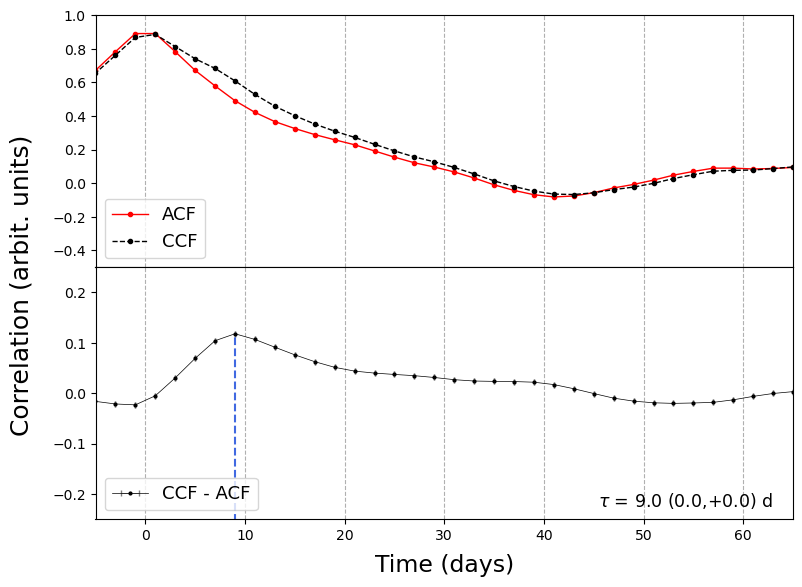

In [137]:
lims_x = (-5,65)
lims_y = (-0.5,1)
err = (err_low*(-1), err_high)

photRM.plot_ccf_acf(final_ccf,ccf,acf,locator=10,peak=True,tau=tau,err=err,lims_x=lims_x,lims_y=lims_y)

In [ ]:
#### IMPROVEMENT ###
# as we can see, results are changed when random seed changes
# new time-lag is estimated on ~ 9 days

Time-lag estimated: **33 days** (real value = 34.11 days).

<a class="anchor" id="ref"></a>
# Resources and references

* Alexander, T. 1997, in: Astronomical Time Series, eds. D. Maoz, A. Sternberg, & E. M. Leibowitz, Vol. 218, Springer, [Is AGN Variability Correlated with Other AGN Properties? ZDCF Analysis of Small Samples of Sparse Light Curves](https://ui.adsabs.harvard.edu/abs/1997ASSL..218..163A/abstract)  

* Bentz, M. C., Denney, K. D., Grier, C. J., et al. [2013, ApJ, 767, 149](https://iopscience.iop.org/article/10.1088/0004-637X/767/2/149/pdf)  

* Chelouche, D. & Daniel, E. [2012, ApJ, 747, 62.](https://ui.adsabs.harvard.edu/abs/2012ApJ...747...62C/abstract)  

* Čvorović-Hajdinjak, I., Kovačević, A. B., Ilić, D., et al. [2022, Astronomische Nachrichten, 343, e210103](https://ui.adsabs.harvard.edu/abs/2022AN....34310103A/abstract)  

* Edri, H., Rafter, S. E., Chelouche, D., et al. [2012, ApJ, 756, 73](https://ui.adsabs.harvard.edu/abs/2012ApJ...756...73E/abstract)  

* Ivezić, Ž., Kahn, S. M., Tyson, J. A., et al. [2019, ApJ, 873, 111](https://ui.adsabs.harvard.edu/abs/2019ApJ...873..111I/abstract)  

* Jankov, I., Kovačević A. B., Ilić, D., et al. [2022, Astronomische Nachrichten, 343, e210090](https://ui.adsabs.harvard.edu/abs/2022AN....34310090J/abstract)  

* Kelly, B. C., Bechtold, J., & Siemiginowska, A. [2009, ApJ, 698, 895.](https://ui.adsabs.harvard.edu/abs/2009ApJ...698..895K/abstract)  

* Kovačević, A., Popović, L. Č., Shapovalova, A. I., et al. [2014, Advances in Space Research, 54, 1414-1428](https://ui.adsabs.harvard.edu/abs/2014AdSpR..54.1414K/abstract)  

* Kovačević, A., Ilić, D., Jankov, I. et al. [2021a, arXiv:2105.12420](https://ui.adsabs.harvard.edu/abs/2021arXiv210512420K/abstract)  

* Kovačević, A. B., Ilić, D., Popović, L. Č., et al. [2021b, MNRAS, 505, 5012](https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5012K/abstract)   

* Kovačević, A. B., Radović, V., Ilić, D., et al. [2022, ApJS, 262, 2](https://iopscience.iop.org/article/10.3847/1538-4365/ac88ce)  

* Laursen, P., Sommer-Larsen, J., Milvang-Jensen, B., et al. [2019, A&A, 627, A84](https://doi.org/10.1051/0004-6361/201833645)

* Sánchez-Sáez, P., Lira, H., Martí, L., et al. [2021, AJ, 162, 206](https://ui.adsabs.harvard.edu/abs/2021AJ....162..206S/abstract)  

* Shankar, F., Weinberg, D. H., & Miralda-Escude, J. [2009, ApJ, 690, 20](https://iopscience.iop.org/article/10.1088/0004-637X/690/1/20/pdf)  

* Shapovalova, A. I., Popović, L. Č., Afanasiev, V. L., et al. [2019, MNRAS, 485, 4790-4803](https://ui.adsabs.harvard.edu/abs/2019MNRAS.485.4790S/abstract)  

* Vanden Berk, D. E., Richards, G. T., Bauer, A., et al. [2001, AJ, 122, 549](https://ui.adsabs.harvard.edu/abs/2001AJ....122..549V/abstract)  

* Woo, J. H., & Urry, C. M. [2002, ApJ, 579, 530](https://iopscience.iop.org/article/10.1086/342878/fulltext/)